In [1]:
# imports

from datetime import datetime, timedelta

# set up file paths and other data globals

import config
import modify

# local imports

from covid_package.data_funcs.update_data import check_refresh_data
from covid_package.data_funcs.store_data import read_json_data, convert_owid_data

from covid_package.libs.aggregate_data import fetch_latest_data_date, fetch_date_list
from covid_package.libs.compile_dict import collate_data, collate_plot_data

from covid_package.api.get_country_data import get_l2_date_data

from covid_package.plots.single_plot import one_plot
from covid_package.plots.double_plot import two_plots
from covid_package.plots.multi_plot import multi_plots

print("Imports complete")

Imports complete


In [2]:
# check if data up to date; if not, reload

if check_refresh_data():

    # read the updated(?) data file from the data dir
    data = read_json_data(config.DATA_FILE_STR)
    
    # convert the OWID_ data so that we don't trip up fetch_latest_data_date
    data = convert_owid_data(data)
    
    # set the latest data date global
    config.LATEST_DATA_DATE = fetch_latest_data_date(data)
    
    print("Latest data is:", config.LATEST_DATA_DATE)
    print("Current UTC 0 datetime = {}".format(datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S%z")))

Checking that data is up to date
Data file up to date: last updated at: 2022-01-18T05:04:22Z
Latest data is: 2022-01-17
Current UTC 0 datetime = 2022-01-18T06:05:30


In [3]:
# restrict analysis dates if required
 
start_date = config.DATA_START_DATE
end_date = config.LATEST_DATA_DATE

start_date = '2021-07-01'
#end_date = '2021-01-01'
analysis_window = 0
#analysis_window = 28

# restrict the analysis to the last N days from the end_date

if analysis_window > 0:
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")
    start_date_obj = end_date_obj - timedelta(days = analysis_window)
    start_date = datetime.strftime(start_date_obj, "%Y-%m-%d")
    
# compile the date_list to the default range or a restricted range
if (start_date > config.DATA_START_DATE) or (end_date < config.LATEST_DATA_DATE):
    # get a restrictive list of valid data dates
    date_list = fetch_date_list(data, start_date = start_date, end_date = end_date)
else: # just compile all available dates into date_list
    # get an exhaustive list of date objects containing VALID DATA
    date_list = fetch_date_list(data)
    
print("Analysis window is from {} to {}".format(start_date, end_date))

Analysis window is from 2021-07-01 to 2022-01-17


In [4]:
# set up chart_labels dict

chart_labels = dict()

# define plot values
chart_labels['width'] = 15
chart_labels['height'] = 10
chart_labels['tsize'] = 16
chart_labels['fsize'] = 12
chart_labels['lsize'] = 10

In [5]:
# define the list of required resources
res = ['people_fully_vaccinated_per_hundred', 'icu_patients_per_million']

chart_labels['expl_str'] = "Vaccination & ICU"
chart_labels['descr_str_1'] = res[0].replace('_', ' ').capitalize()
chart_labels['descr_str_2'] = res[1].replace('_', ' ').capitalize()

# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, date_list, res)
    
#print(country_date_data)

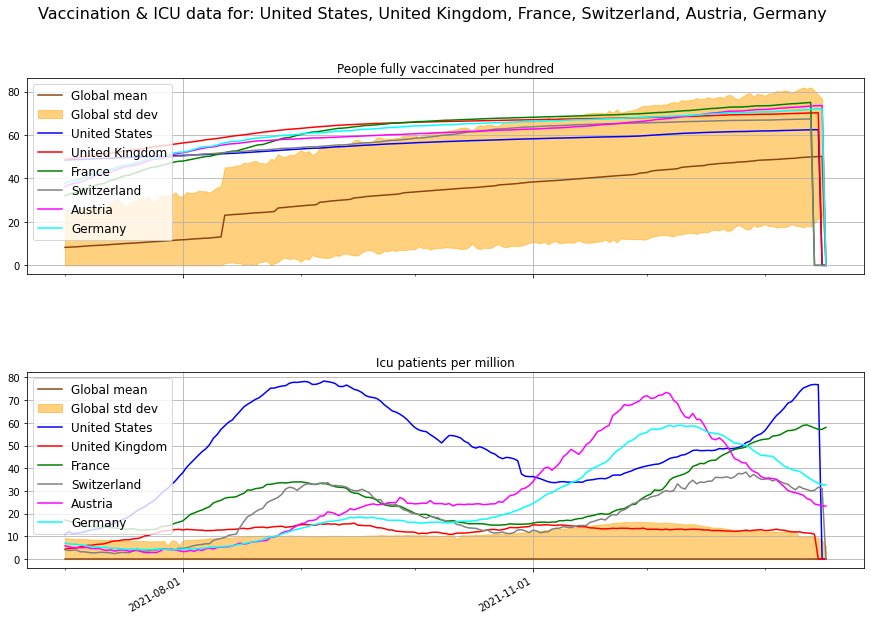

In [6]:
# re-juggle the data for a multi country chart

# the countries being analyzed
chart_labels['y_isos'] = ['USA', 'GBR', 'FRA', 'CHE', 'AUT', 'DEU']

plot_data = collate_plot_data(chart_labels['y_isos'], country_date_data)

# assemble the locations list
chart_labels['y_axis_labels'] = []
for iso in chart_labels['y_isos']:
    chart_labels['y_axis_labels'].append(data[iso]['location'])
    
# call multi_plots
multi_plots(chart_labels, plot_data)